# Preprocessing of the Twitter Data

**Set up path**

In [3]:
import sys
import os
PATH = "/home/piotr/projects/twitter"
sys.path.append(os.path.join(PATH, "src"))
PATH_RECORD = os.path.join(PATH, "data/clean/record.json") #path to store records
START = '2020_02_22' #start date (first file)
END = '2020_07_20' #end date (last file)
PATH_PREPROCESSED = os.path.join(PATH, 'data/clean') #data path

**Import libraries**:

In [4]:
import logging
import pickle
import json
import ast
import datetime
import pdb
import gc
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from collections import defaultdict
from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import StratifiedShuffleSplit

from twitter_tools.preprocessing import Preprocessor
from twitter_models.embeddings import OutlierDetector
from twitter_tools.utils import read_files, batch

from dask import dataframe as dd
from dask.diagnostics import ProgressBar


PATH_STOPWORDS = '/home/piotr/nlp/polish.stopwords.txt'
stopwords = []
with open(PATH_STOPWORDS, 'r') as f:
    for line in f:
        stopwords.append(line.strip('\n'))
stopwords.append('mieć')

dtypes = json.load(open(os.path.join(PATH, 'results/cleaning/dtypes.json'), 'r'))

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


**Setup logging:**

In [5]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

## Preprocessing and lemmatization:

The preprocessing and lemmatization is performed through the `Preprocessor` class, which performs the following task:
- ensures integrity of each record, drops it if any problems occur - for example, unexpected data types key fields containing text, user IDs or Tweet date
- drops Tweets marked as having a different language than Polish or undefined
- removes URLs, numbers, emojis and user mentions from each Tweet's text
- replaces hashtags included in Tweets with words
- marks the retweets in the dataset
- tokenizes the text, performs POS tagging and lemmatization on each of the texts using the preprocessing Pipeline from the `stanza` library. Two separate fields are kept - `tokenized` for tokenized data after the preprocessing steps mentioned above and `lemmatized` for fully lemmatized data
- no stopword removal is performed at this point
- computes the proportion of Polish tokens in the data using the spell checker from the `pyenchant` library

First, I set up the parameters for preprocessing - chunk size for the preprocessor, etc.

In [5]:
keep_cols = ['full_text', 'created_at', 'id_str', 'user-id_str'] #columns to be kept
chunk_size = 10000 #chunk size for CSV reader
pos_batch_size = 1000 #batch size for POS tagger

Define function for filtering out file names between specified range of dates:

In [6]:
def filter_date(name, start, end, regex = '\d{4}\_\d{2}\_\d{2}', fmt = '%Y_%m_%d'):
    date = re.search(regex, name).group(0)
    date, start, end = map(lambda x: datetime.datetime.strptime(x, fmt), [date, start, end])
    return date >= start and date <= end

Define function to run the preprocessor iteratively through files in chunks:

In [13]:
def preprocess(path_raw:str, path_preprocessed:str, keep_cols:list, 
               date_from:str, date_to:str, path_record:str = None, 
               chunk_size:int = 10000, pos_batch_size:int = 1000):
    """
    path_raw:: str, folder containing raw files
    path_preprocessed:: str, folder to store preprocessed files
    keep_cols:: list, columns to keep
    date_from:: str, date from which to start in format %Y_%m_%d
    date_to:: str, date on which to end in format %Y_%m_%d
    path_record:: str, path to json record file - stores number of rows iterated over in each preprocessed files
    chunk_size:: int, chunk size for the file loader
    pos_batch_size:: int, batch size for the POS tagger
    """
    #record:
    if path_record and os.path.isfile(path_record):
        record = json.load(open(path_record, "r"))
        record = defaultdict(lambda: 0, record)
    else:
        record = defaultdict(lambda: 0)
    
    #get files in the specified dates:
    files = [f for f in os.listdir(path_raw) if 'csv' in f and filter_date(f, start = date_from, end = date_to)]
    preprocessor = Preprocessor(keep_cols = keep_cols, pos_batch_size = pos_batch_size) #init
    
    #iterate through files:
    for file in tqdm(sorted(files)):
        
        path_source = os.path.join(path_raw, file) #path to read raw file from
        path_target = os.path.join(path_preprocessed, file) #path to write preprocessed file to
        
        names = pd.read_csv(path_source, dtype = str, nrows = 1, index_col = 0).columns #get column names
        
        #preprocess csv by chunk:
        for df in pd.read_csv(path_source, iterator = True, dtype = str, 
                               skiprows = record[path_source] + 1,
                               chunksize = chunk_size, index_col = 0, 
                               names = names):
            res = preprocessor.preprocess(df)

            if res is not None:

                if os.path.isfile(path_target):
                    res.to_csv(path_target, mode = "a", header = False) #append if exists
                else:
                    res.to_csv(path_target, mode = "w") #else write to new

                record[path_source] += chunk_size

                if path_record:
                    json.dump(dict(record), open(path_record, "w"))
        gc.collect()

#### Preprocess government tweets 

In [31]:
PATH_RAW = '/media/piotr/SAMSUNG/data/gov'
preprocess(PATH_RAW, PATH_PREPROCESSED, keep_cols = keep_cols, path_record = PATH_RECORD,
          chunk_size = 10000, pos_batch_size = 1000, date_from = start, date_to = end)

2020-07-23 18:13:07 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-07-23 18:13:07 INFO: Loading these models for language: pl (Polish):
| Processor | Package |
-----------------------
| tokenize  | lfg     |
| pos       | lfg     |
| lemma     | lfg     |

2020-07-23 18:13:07 INFO: Use device: gpu
2020-07-23 18:13:07 INFO: Loading: tokenize
2020-07-23 18:13:07 INFO: Loading: pos
2020-07-23 18:13:08 INFO: Loading: lemma
2020-07-23 18:13:08 INFO: Done loading processors!


#### Preprocess opposition tweets

In [32]:
PATH_RAW = '/media/piotr/SAMSUNG/data/opp'
preprocess(PATH_RAW, PATH_PREPROCESSED, keep_cols = keep_cols, path_record = PATH_RECORD,
          chunk_size = 10000, pos_batch_size = 1000, date_from = start, date_to = end)

2020-07-24 17:06:31 WARNING: Can not find mwt: default from official model list. Ignoring it.
2020-07-24 17:06:31 INFO: Loading these models for language: pl (Polish):
| Processor | Package |
-----------------------
| tokenize  | lfg     |
| pos       | lfg     |
| lemma     | lfg     |

2020-07-24 17:06:31 INFO: Use device: gpu
2020-07-24 17:06:31 INFO: Loading: tokenize
2020-07-24 17:06:31 INFO: Loading: pos
2020-07-24 17:06:32 INFO: Loading: lemma
2020-07-24 17:06:32 INFO: Done loading processors!


## Cleaning

#### Load the data:

In [10]:
data = read_files(PATH_PREPROCESSED, day_from = START, day_to = END, method = 'dask', dtype = dtypes)

- **Removing Tweets in a different language** - Some of the users scraped were using other languages than Polish, rendering any form of NLP analysis of their content difficult. To remove them, I analyzed the average proportion of non-Polish tokens in the lemmatized version of their tweets:

In [65]:
with ProgressBar():
    polishness = data.groupby(['user-id_str']).agg({'polish':'mean'}).compute()
    drop_users = polishness[polishness['polish'] < 0.4].index.tolist()
    print(f"Number of non-Polish users {len(drop_users)}")
    print("Example tweets:")
    tweets_nonpolish = data[data['user-id_str'].isin(drop_users)].sample(frac = 0.1, random_state = 1234).compute()

[########################################] | 100% Completed |  2min  5.0s
Number of non-Polish users 64
Example tweets:
[########################################] | 100% Completed |  2min  0.4s


In [66]:
for i in tweets_nonpolish['lemmatized']:
    print("-" + i)

-adventura natura traveling photograph
-adventura traseltheworld natura travelling
-hong kong polika terrorism hongkongponicetalicata ccpvirus ccpcoro n avirus
-champion mp austin grooming gangs
-you
-china lied people died
-flowerphotograph photo plant beautiful rose plants floral
-just posted ymię aitidiem у косачеву on reddit
-wuhan corona virus coronavirus covid
-ventil covid coronavirus
-quebec covid
-happy new week twitter world painting art lovers
-wciąż aktualny żeby nikt się nie zdziwić jak się obudzić pewien dzień kazać on opuścić własny dom wykupywać manhattan rumunia węgry polska być wszędzie hektar hektar hektar shimon perez być prezydent izrael
-just posted юля сбросила dziąć on reddit
-sickof hajdu tam
-just posted ezoniet yidied ydizia н ydizia mieć on reddit
-cdnpolić coronavirus pandemic
-wtf
-just posted ydizia yidied из aitidiem on reddit
-just posted ydizia закончился dziąć on reddit
-just posted facebook dii aitidiem ydizia происхождения on reddit
-talmud
-just po

- **Removing bots/users with suspicious levels of activity** - drop users with extremely high number of daily Tweets (excluding Retweet activity). 'Extremely active' is understood as users with higher activity than the 99th quantile of the average daily number of tweets.

[########################################] | 100% Completed |  2min  7.5s
user-id_str
1223528125952417792    286.300000
28522629               161.250000
2188644971             151.123457
818748422866006016     145.523077
1240226312796676097    126.157895
                          ...    
2338864224               1.000000
1163156949455777792      1.000000
1163409086991478784      1.000000
2333783572               1.000000
332207504                1.000000
Length: 9326, dtype: float64


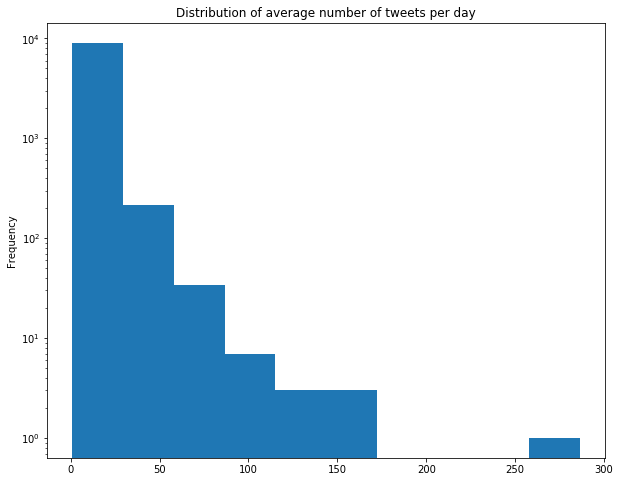

In [67]:
with ProgressBar():
    counts = data.loc[np.logical_not(data['retweet']),:].groupby(['user-id_str','day']).size().compute()
counts_avg = counts.groupby('user-id_str').mean()
print(counts_avg.sort_values(0, ascending = False))
counts_avg.plot.hist(figsize = (10, 8), legend = None, title = 'Distribution of average number of tweets per day')
plt.yscale('log')
plt.show()

I added the user tho tweeted 286 times per day to the list of profiles to be removed. The profile was later removed, so it seems like this could have been a bot activity.

In [68]:
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
lim = counts_avg.quantile(0.9999)
print(f'99.999th quantile of original tweet numbers per day {lim}')
high_activity = counts_avg[counts_avg > lim].reset_index()['user-id_str'].tolist()
print(f'Number of highly active ids {len(high_activity)}')
drop_users = list(set(drop_users + high_activity))
json.dump(drop_users, open(PATH_DROP, 'w'))

99.999th quantile of original tweet numbers per day 169.6908749998999
Number of highly active ids 1


Finally, get ids of individual tweets that are not in Polish (e.g. bi-lingual users)

[                                        ] | 0% Completed |  0.0s

/home/piotr/anaconda3/envs/nlp/lib/python3.8/site-packages/dask/dataframe/core.py:1334: UserWarning: sample does not support the number of sampled items parameter, 'n'. Please use the 'frac' parameter instead.
  warnings.warn(msg)


[########################################] | 100% Completed |  2min  6.1s


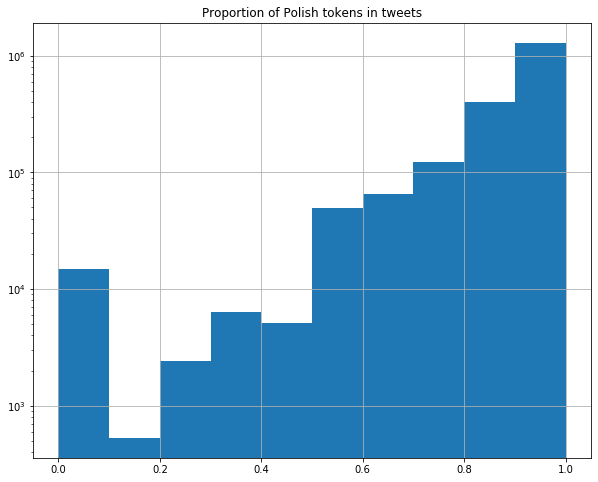

In [71]:
with ProgressBar():
    fig, ax = plt.subplots(1, 1, figsize = (10,10))
    ax.set_title('Proportion of Polish tokens in tweets')
    data.loc[np.logical_not(data['user-id_str'].isin(drop_users))].polish.sample(0.2).compute().hist(figsize = (10, 8), ax = ax)
    plt.yscale('log')
    plt.show()

In [75]:
with ProgressBar():
    drop_tweets = data['id_str'][data.polish <= 0.5].compute()
drop_tweets = drop_tweets.tolist()


## Tweets containing only stopwords:

In [8]:
data = read_files(PATH_PREPROCESSED, day_from = START, day_to = END, method = 'dask',
                  usecols = ['lemmatized','user-id_str','id_str'], dtype = dtypes)

In [13]:
with ProgressBar():
    stop_tweets = data['id_str'][data.lemmatized.astype(str).apply(lambda x: all([w in stopwords for w in x.split()]), meta = ('lemmatized','bool'))].compute(num_workers = 4)

[########################################] | 100% Completed | 14min  6.8s


In [14]:
drop_tweets.extend(stop_tweets.tolist())
drop_tweets = list(set(drop_tweets))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
json.dump(drop_tweets, open(PATH_DROP, 'w'))

### Export all clean data to one file:

In [30]:
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
drop_tweets = json.load(open(PATH_DROP, 'r'))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
drop_users = json.load(open(PATH_DROP, 'r'))
PATH_PREPROCESSED = os.path.join(PATH, 'data/clean')
PATH_EMBEDDINGS = '/home/piotr/nlp/cc.pl.300.vec'

#filter function:
def filter_fun(df, drop_users, drop_tweets):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets)

In [31]:
FILENAME = 'all_tweets.txt'
with open(os.path.join(PATH_PREPROCESSED, FILENAME), 'a') as f:
    for df in tqdm(read_files(PATH_PREPROCESSED, day_from = START, day_to = END, method = 'pandas', dtype = dtypes, filter_fun = ff)):
        for line in df.lemmatized.tolist():
            f.write(line + '\n')

In [ ]:
! /home/piotr/nlp/glove/glove_train.sh

## Outlier removal
- next, using the Sentence Embeddings method (based on fasttext vectors with 300 dimensions), I identify potential outliers in the data using the IsolationForrest algorithm and remove them

Reload the drop ids:

In [20]:
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_tweets.json')
drop_tweets = json.load(open(PATH_DROP, 'r'))
PATH_DROP = os.path.join(PATH, 'results/cleaning/drop_users.json')
drop_users = json.load(open(PATH_DROP, 'r'))
PATH_PREPROCESSED = os.path.join(PATH, 'data/clean')
PATH_EMBEDDINGS = '/home/piotr/nlp/cc.pl.300.vec'

#filter function:
def filter_fun(df, drop_users, drop_tweets, drop_duplicates = True):
    df = df[np.logical_not(df['user-id_str'].isin(drop_users))] #drop IDs that are to be excluded
    df = df[np.logical_not(df['id_str'].isin(drop_tweets))]
    if drop_duplicates:
        df.drop_duplicates(inplace = True)
    return df
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets, drop_duplicates = True)

#### Train the outlier detector:

In [23]:
PATH_DETECTOR = os.path.join(PATH, 'results/cleaning/outlier_detector.p')
if os.path.isfile(PATH_DETECTOR):
    detector = pickle.load(open(PATH_DETECTOR, 'rb'))
else:
    with ProgressBar():
        data = read_files(PATH_PREPROCESSED, day_from = START, day_to = END, method = 'dask', filter_fun = ff,
                          usecols = ['lemmatized','user-id_str','id_str'], dtype = dtypes)
        #get a sample to train the detector:
        train = data.sample(0.05).compute()
        train.lemmatized = train.lemmatized.progress_apply(lambda x: [w for w in x.split() if w not in stopwords])
        detector = OutlierDetector(PATH_EMBEDDINGS, IsolationForest(n_jobs = 3), a = 0.01) #init detector
        detector.fit(train.lemmatized)
        pickle.dump(detector, open(PATH_DETECTOR, 'wb')) #save model

Predict on unique:

In [ ]:
data = read_files(PATH_PREPROCESSED, day_from = START, day_to = END, method = 'dask', filter_fun = ff,
                  usecols = ['lemmatized','user-id_str','id_str', 'day'], dtype = dtypes)
pred_fun = lambda x: detector.predict([w for w in x.split() if w not in stopwords])
#predict outliers
with ProgressBar():
    outliers = data['lemmatized'][data.groupby('day').lemmatized.apply(pred_fun, meta = ('lemmatized','float')) < 0].compute()

Now load the data again without dropping the duplicates and get a list of all tweet ids tagged as duplicates

In [ ]:
ff = partial(filter_fun, drop_users = drop_users, drop_tweets = drop_tweets, drop_duplicates = False)
data = read_files(PATH_DATA, day_from = START, day_to = END, method = 'dask', filter_fun = ff,
                  usecols = ['lemmatized','user-id_str','id_str'], dtype = dtypes)
with ProgressBar():
    outliers_text = data.loc[outliers == 1]['lemmatized'].tolist().compute()
    print(outliers_text[:50])
    outlier_ids = data.loc[data['lemmatized'].isin(outliers_text), ('id_str')].compute()

## Final step
Get ids of all tweets that should be removed based on the previous analysis + all with below 0.5 words in Polish

In [32]:
drop_users = json.load(open(os.path.join(path, 'results/cleaning/users_drop_ids.json'), 'r'))
outliers = json.load(open(os.path.join(path, 'results/cleaning/outliers.json'), 'r'))
def get_ids(df, drop_users: list, drop_tweets: list):
    drop = df['user-id_str'].isin(drop_users) #drop users that are to be excluded
    drop |= df['id_str'].isin(drop_tweets) #drop tweets that are to be excluded
    drop |= df.polish.astype(float) < 0.5 #drop tweets with less than 50% Polish
    ids = df.loc[drop, ('id_str')].tolist() #get ids
    return ids

In [37]:
path_tmp = os.path.join(path, 'results/cleaning/DROP_IDS.json')
if not os.path.isfile(path_tmp):
    ids_drop = []
    for df in tqdm(read_files(path_preprocessed, 84, prefixes = ["opp", "gov"], dtype = str)):
        ids_drop.extend(get_ids(df, drop_users = drop_users, drop_tweets = outliers))
    json.dump(ids_drop, open(path_tmp, 'w'))